# Best Practices for training CEBRA models

We start by showing you how how to get started with CEBRA:

- Define a CEBRA-Time model (we strongly recommend starting with this).
- Load data.
- Perform train/validation splits.
- Train the model.
- Check the loss functions.
- Save the model & reload.
- Transform the model on train/val.
- Evaluate Goodness of Fit.
- Visualize the embeddings.
- Compute and display the Consistency between runs (n=10).
- Run a (small) grid search for model parameters.

Once you have a good CEBRA-Time model, then you can do hypothesis testing with CEBRA-Behavior:
- Define a CEBRA-Behavior model.
- as above, train, check, evaluate, transform, and test consistency.
- Run controls with shuffled data - which is critical for label-guided embeddings.


In [ ]:
!pip install --pre 'cebra[datasets,integrations]'

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra.datasets
from cebra import CEBRA

#for model saving:
import os
import tempfile
from pathlib import Path

# 1. Set up a CEBRA model

## Items to consider

- We recommend starting with an unsupervised approach (CEBRA-Time).
- We recommend starting with defaults, perform the sanity checks we suggest below, then performing a grid search if needed.
- We are going to largely follow the recommendations from our [Quick Start scikit-learn API](https://cebra.ai/docs/usage.html#quick-start-scikit-learn-api-example)

In [3]:
# 1. Define a CEBRA model
cebra_model = CEBRA(
    model_architecture="offset10-model", #consider: "offset10-model-mse" if Euclidean
    batch_size=512,
    learning_rate=3e-4,
    temperature=1.12,
    max_iterations=5000, #we will sweep later; start with default
    conditional='time', #for supervised, put 'time_delta', or 'delta'
    output_dimension=3,
    distance='cosine', #consider 'euclidean'; if you set this, output_dimension min=2
    device="cuda_if_available",
    verbose=True,
    time_offsets=10
)

# 2. Load the data

- (or adapt and use your data)
- We are going to use demo data. The data will be automatically downloaded into a `/data` folder.

In [4]:
#2. example data
%mkdir data
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

100%|██████████| 10.0M/10.0M [00:01<00:00, 9.55MB/s]

Download complete. Dataset saved in 'data/rat_hippocampus/achilles.jl'


### Visualize the data

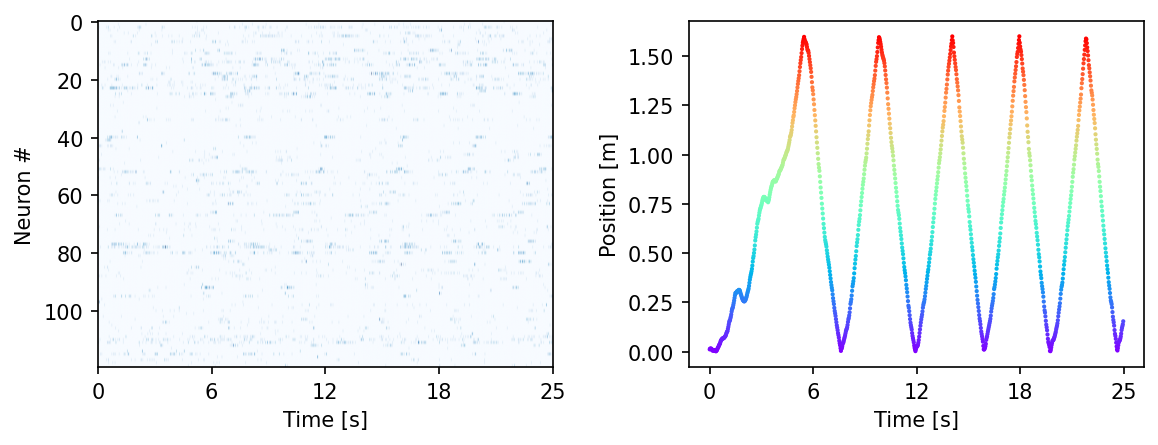

In [5]:
fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(hippocampus_pos.neural.numpy()[:1000].T, aspect = 'auto', cmap = 'Blues')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), hippocampus_pos.continuous_index[:1000, 0],
            c=hippocampus_pos.continuous_index[:1000, 0], cmap='rainbow', s=1)

plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))
plt.show()

## Quick test: Train CEBRA-Time on the full data (not train/validation yet)...

- This is a rapid quick start, just training without labels on the full dataset on the model we set up above! Here, we should already see a nice structured embedding.
- Note, the colors here are post-hoc applied; positional information was not used to train the model.

pos: -0.8565 neg:  6.3679 total:  5.5114 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 109.68it/s]
100%|██████████| 500/500 [00:01<00:00, 289.90it/s]


 GoF in bits - full: 1.0429265174659843


<Figure size 500x500 with 0 Axes>

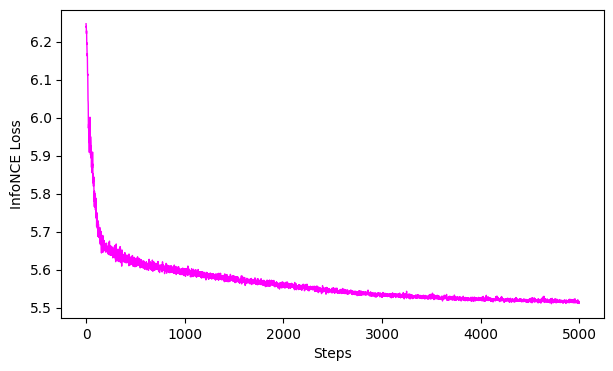

In [6]:
# fit
cebra_time_full_model = cebra_model.fit(hippocampus_pos.neural)
# transform
cebra_time_full = cebra_model.transform(hippocampus_pos.neural)
# GoF
gof_full = cebra.sklearn.metrics.goodness_of_fit_score(cebra_time_full_model, hippocampus_pos.neural)
print(" GoF in bits - full:", gof_full)
# plot embedding
fig = cebra.integrations.plotly.plot_embedding_interactive(cebra_time_full, embedding_labels=hippocampus_pos.continuous_index[:,0], title = "CEBRA-Time (full)", markersize=3, cmap = "rainbow")
fig.show()
# plot the loss curve
ax = cebra.plot_loss(cebra_time_full_model)

# 3. Create a Train/Validation Split

- now that we know we get something decent (see structure, proper loss curve), we can properly test parameters.

In [7]:
# 3. Split data and labels
from sklearn.model_selection import train_test_split
split_idx = int(0.8 * len(hippocampus_pos.neural)) #suggest: 5%-20% depending on your dataset size

train_data = hippocampus_pos.neural[:split_idx]
valid_data = hippocampus_pos.neural[split_idx:]

train_continuous_label = hippocampus_pos.continuous_index.numpy()[:split_idx]
valid_continuous_label = hippocampus_pos.continuous_index.numpy()[split_idx:]


# 4. Fit the train split model

In [8]:
cebra_train_model = cebra_model.fit(train_data)#, train_continuous_label)

pos: -0.8543 neg:  6.3653 total:  5.5110 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 108.87it/s]


# 5. Save the model [optional]

In [9]:
tmp_file = Path(tempfile.gettempdir(), 'cebra.pt')
cebra_train_model.save(tmp_file)
#reload
cebra_train_model = cebra.CEBRA.load(tmp_file)

# 6. Compute (tranform) the embedding on train and validation data

In [10]:
train_embedding = cebra_train_model.transform(train_data)
valid_embedding = cebra_train_model.transform(valid_data)

# 7. Evaluate the Model
- Plot the loss curve
- We can also look at the Goodness of Fit this in bits vs. the infoNCE loss. [See more info here](https://cebra.ai/docs/api/sklearn/metrics.html#cebra.integrations.sklearn.metrics.goodness_of_fit_score)
 - ProTip: 0 bits would be a perfectly collapsed embedding.

100%|██████████| 500/500 [00:01<00:00, 286.49it/s]


 bits - train: 1.040366147077114


100%|██████████| 500/500 [00:01<00:00, 287.12it/s]


 bits - valid: 0.4091711424705838


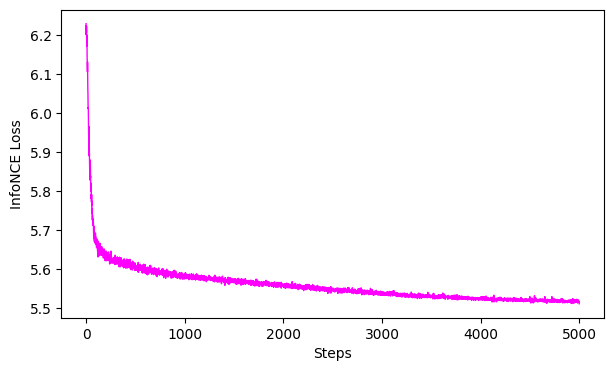

In [11]:
gof_train = cebra.sklearn.metrics.goodness_of_fit_score(cebra_train_model, train_data)
print(" bits - train:", gof_train)

gof_valid = cebra.sklearn.metrics.goodness_of_fit_score(cebra_train_model, valid_data)
gof_valid
print(" bits - valid:", gof_valid)

# plot the loss curve
ax = cebra.plot_loss(cebra_train_model)

## Visualize the embeddings

- train, then validation

In [12]:
import cebra.integrations.plotly
#train
fig = cebra.integrations.plotly.plot_embedding_interactive(train_embedding,
                                                           embedding_labels=train_continuous_label[:,0],
                                                           title = "CEBRA-Time Train",
                                                           markersize=3,
                                                           cmap = "rainbow")
fig.show()

#validation
fig = cebra.integrations.plotly.plot_embedding_interactive(valid_embedding,
                                                           embedding_labels=valid_continuous_label[:,0],
                                                           title = "CEBRA-Time-validation",
                                                           markersize=3,
                                                           cmap = "rainbow")
fig.show()

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

# Next sanity/validation step: Consistency

What did we check above?
 - (1) do we see structure in our embedding? (if not, something is off!)
 - (2) is the GoF reasonable? (infoNCE low, bits high)
 - (3) Is the loss converging without overfitting (no sudden drop after many interations?)

IF 1-3 are not satisfactory, skip to the **Grid Search Below!**

Beyond these being met, we need to check the consistency across runs! In addition to the above checks, once we have a converging model that produces **consistent embeddings**, then we know we have good model parameters! 🚀

In [13]:
# Now we are going to run our train/val. 10 times to be sure they are consistent!

X = 10  # Number of training runs
model_paths = []  # Store file paths

for i in range(X):
    print(f"Training 🦓CEBRA model {i+1}/{X}")

    # Train and save model
    cebra_train_model = cebra_model.fit(train_data)
    tmp_file = Path(tempfile.gettempdir(), f'cebra_{i}.pt')
    cebra_train_model.save(tmp_file)
    model_paths.append(tmp_file)

# Reload models and transform data
train_embeddings = []
valid_embeddings = []

for tmp_file in model_paths:
    cebra_train_model = cebra.CEBRA.load(tmp_file)
    train_embeddings.append(cebra_train_model.transform(train_data))
    valid_embeddings.append(cebra_train_model.transform(valid_data))

Training 🦓CEBRA model 1/10


pos: -0.8545 neg:  6.3701 total:  5.5156 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 109.74it/s]


Training 🦓CEBRA model 2/10


pos: -0.8399 neg:  6.3691 total:  5.5293 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 109.63it/s]


Training 🦓CEBRA model 3/10


pos: -0.8557 neg:  6.3676 total:  5.5119 temperature:  1.1200: 100%|██████████| 5000/5000 [00:46<00:00, 108.58it/s]


Training 🦓CEBRA model 4/10


pos: -0.8525 neg:  6.3695 total:  5.5170 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 109.77it/s]


Training 🦓CEBRA model 5/10


pos: -0.8543 neg:  6.3675 total:  5.5132 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 109.13it/s]


Training 🦓CEBRA model 6/10


pos: -0.8498 neg:  6.3695 total:  5.5197 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 109.80it/s]


Training 🦓CEBRA model 7/10


pos: -0.8567 neg:  6.3706 total:  5.5139 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 110.24it/s]


Training 🦓CEBRA model 8/10


pos: -0.8558 neg:  6.3689 total:  5.5131 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 110.77it/s]


Training 🦓CEBRA model 9/10


pos: -0.8458 neg:  6.3702 total:  5.5244 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 109.52it/s]


Training 🦓CEBRA model 10/10


pos: -0.8520 neg:  6.3698 total:  5.5178 temperature:  1.1200: 100%|██████████| 5000/5000 [00:45<00:00, 109.42it/s]


### Compute Consistency Across Runs
- Now that we have 10 runs of train, we can compute the consistency between runs.
- TRAIN: This should be high (in the 90's on the train embeddings)!
- VALID: Depending on how large your validation data are, this also should be as high.
 - In our demo data, the cebra-time on rat 1 with 20% held out is in the 70's for 5K iterations, which is acceptable.

<Axes: >

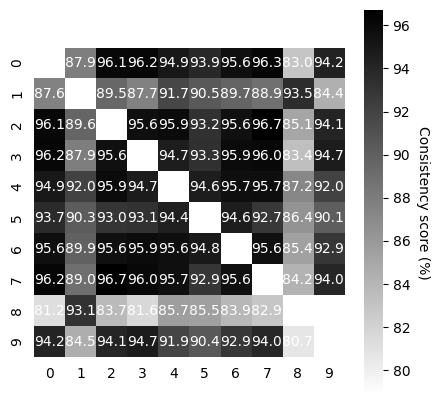

In [14]:
scores, pairs, ids_runs = cebra.sklearn.metrics.consistency_score(
    embeddings=train_embeddings,
    between="runs"
)

cebra.plot_consistency(scores, pairs, ids_runs)

<Axes: >

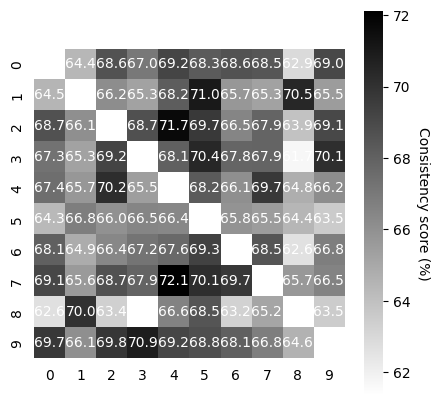

In [15]:
scores, pairs, ids_runs = cebra.sklearn.metrics.consistency_score(
    embeddings=valid_embeddings,
    between="runs"
)

cebra.plot_consistency(scores, pairs, ids_runs)

# What if I don't have good parameters? Let's do a grid search...

In [16]:
#%mkdir saved_models

params_grid = dict(
    output_dimension = [3, 6],
    time_offsets = [5, 10],
    model_architecture='offset10-model',
    temperature_mode='constant',
    temperature=[0.1, 1.0],
    max_iterations=[5000],
    device='cuda_if_available',
    num_hidden_units = [32, 64],
    verbose = True)

datasets = {"dataset1": train_data}
# run the grid search
grid_search = cebra.grid_search.GridSearch()
grid_search.fit_models(datasets, params=params_grid, models_dir="saved_models")

/usr/local/lib/python3.11/dist-packages/cebra/__init__.py:118: UserWarning:

Your code triggered a lazy import of cebra.grid_search. While this will (likely) work, it is recommended to add an explicit import statement to you code instead. To disable this warning, you can run ``cebra.allow_lazy_imports()``.

pos: -9.8859 neg:  16.0099 total:  6.1241 temperature:  0.1000: 100%|██████████| 5000/5000 [00:36<00:00, 137.85it/s]
pos: -9.7278 neg:  16.0244 total:  6.2966 temperature:  0.1000: 100%|██████████| 5000/5000 [00:36<00:00, 138.52it/s]
pos: -0.9845 neg:  9.1652 total:  8.1807 temperature:  1.0000: 100%|██████████| 5000/5000 [00:36<00:00, 138.87it/s]
pos: -0.9692 neg:  9.1654 total:  8.1962 temperature:  1.0000: 100%|██████████| 5000/5000 [00:36<00:00, 138.74it/s]
pos: -9.6068 neg:  14.2719 total:  4.6650 temperature:  0.1000: 100%|██████████| 5000/5000 [00:35<00:00, 140.59it/s]
pos: -9.5413 neg:  14.2796 total:  4.7382 temperature:  0.1000: 100%|██████████| 5000/5000 [00:35<00:00, 140

In [17]:
# Get the results
df_results = grid_search.get_df_results(models_dir="saved_models")

# Get the best model for a given dataset
best_model, best_model_name = grid_search.get_best_model(dataset_name="dataset1", models_dir="saved_models")
print("The best model is:", best_model_name)

The best model is: num_hidden_units_64_output_dimension_6_temperature_0.1_time_offsets_5_dataset1


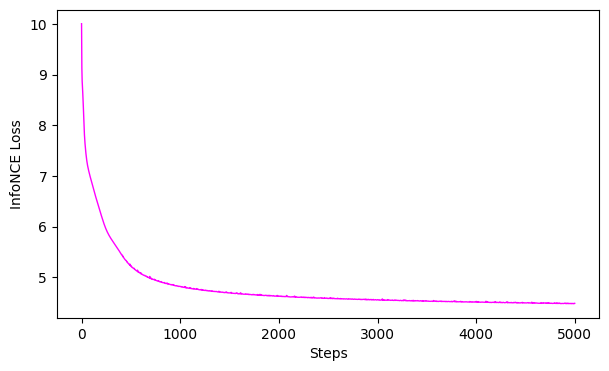

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [18]:
#load the top model ✨
model_path = Path("/content/saved_models") / f"{best_model_name}.pt"
model_path
top_model = cebra.CEBRA.load(model_path)

#transform:
top_train_embedding = top_model.transform(train_data)
top_valid_embedding = top_model.transform(valid_data)

# plot the loss curve
ax = cebra.plot_loss(top_model)


# plot embeddings
fig = cebra.integrations.plotly.plot_embedding_interactive(top_train_embedding,
                                                           embedding_labels=train_continuous_label[:,0],
                                                           title = "top model - train",
                                                           markersize=3,
                                                           cmap = "rainbow")
fig.show()

fig = cebra.integrations.plotly.plot_embedding_interactive(top_valid_embedding,
                                                           embedding_labels=valid_continuous_label[:,0],
                                                           title = "top model - validation",
                                                           markersize=3,
                                                           cmap = "rainbow")
fig.show()


# CEBRA-Behavior: using auxiliary labels for hypothesis testing

- Now that you have good parameters for a self-supervised embedding, the next goal is to understand which behavioral labels are contributing to the model fit.
- Thus, we will use labels, such as position, for testing.
- ⚠️ We don't reimplement the above train/val testing again, but please do. You can also see a demo in the main hippocampus notebook for train/val with labels if you have any doubts.

In [19]:
# Define the model
# consider changing based on search/results above
cebra_behavior_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=5000,
                        distance='cosine',
                        conditional='time_delta', #using labels
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

pos: -0.8915 neg:  6.4163 total:  5.5248 temperature:  1.0000: 100%|██████████| 5000/5000 [00:47<00:00, 106.29it/s]
100%|██████████| 500/500 [00:01<00:00, 270.35it/s]

 GoF in bits - full: 1.0362661343391315


<Figure size 500x500 with 0 Axes>

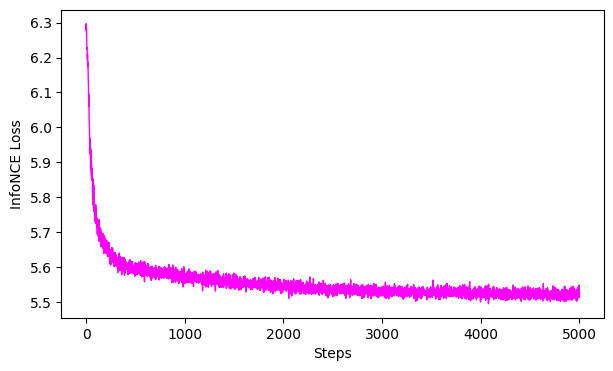

In [20]:
# fit
cebra_behavior_full_model = cebra_behavior_model.fit(hippocampus_pos.neural,hippocampus_pos.continuous_index.numpy())
# transform
cebra_behavior_full = cebra_behavior_full_model.transform(hippocampus_pos.neural)
# GoF
gof_full = cebra.sklearn.metrics.goodness_of_fit_score(cebra_behavior_full_model, hippocampus_pos.neural,hippocampus_pos.continuous_index.numpy())
print(" GoF in bits - full:", gof_full)
# plot embedding
fig = cebra.integrations.plotly.plot_embedding_interactive(cebra_behavior_full, embedding_labels=hippocampus_pos.continuous_index[:,0], title = "CEBRA-Behavior (full)", markersize=3, cmap = "rainbow")
fig.show()
# plot the loss curve
ax = cebra.plot_loss(cebra_behavior_full_model)

# The next items to do when using labels are to perform shuffle controls

**Why do we do this?**
It is entirely expected that the distribution of the labels shape the embedding (see [Proposition 7, Supplementary Note 2](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-023-06031-6/MediaObjects/41586_2023_6031_MOESM1_ESM.pdf)). In [Figure 2c](https://www.nature.com/articles/s41586-023-06031-6#Fig2) we therefore show shuffle controls should be performed, and demonstrate that if **labels are shuffled**, it is not possible to fit them.

- In our paper we shuffle the labels across time. When the `time_delta` strategy for positive sampling is used, this changes the distribution of the positive samples. We do this kind of control to show that fitting a model on nonsensical label structure (in a real experiment, this would be a behavior time series without connection to the neural data) is not possible (assuming a sufficiently large dataset).

Another approach is to shuffle the neural data. However, if the model has sufficient capacity (is large), the data is limited, and one trains too long, it *can* fit a “lookup table” from input data to the output embedding to match the label distribution (because this is intact and still has structure). Thus, this can be useful to be sure you are not overparameterizing or training too long!

- If you shuffle the neural data, the question is whether the label structure can be forced on a latent representation of the shuffled data. This will be possible as long as the model has enough capacity to fit a lookup table, where for each timepoint the embedding is arranged to fit the behavior.

## Label-Shuffle Control

In [21]:
# Label Shuffle control model:
cebra_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=5000,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [22]:
### Shuffle the behavior variable and use it for training
shuffled_pos = np.random.permutation(hippocampus_pos.continuous_index[:,0])

pos: -0.6446 neg:  6.8055 total:  6.1608 temperature:  1.0000: 100%|██████████| 5000/5000 [00:46<00:00, 107.33it/s]
100%|██████████| 500/500 [00:01<00:00, 269.64it/s]

 GoF in bits - full: 0.009072909008859332


<Figure size 500x500 with 0 Axes>

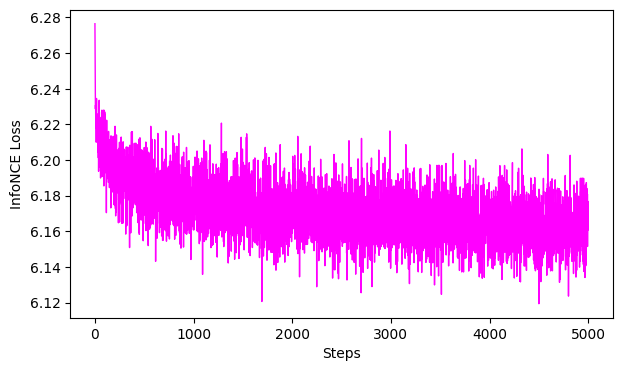

In [23]:
#fit, transform
cebra_shuffled_model.fit(hippocampus_pos.neural, shuffled_pos)
cebra_pos_shuffled = cebra_shuffled_model.transform(hippocampus_pos.neural)
# GoF
gof_full = cebra.sklearn.metrics.goodness_of_fit_score(cebra_shuffled_model, hippocampus_pos.neural,hippocampus_pos.continuous_index.numpy())
print(" GoF in bits - full:", gof_full)
# plot embedding
fig = cebra.integrations.plotly.plot_embedding_interactive(cebra_pos_shuffled, embedding_labels=hippocampus_pos.continuous_index[:,0], title = "CEBRA-Behavior (labeled shuffled)", markersize=3, cmap = "rainbow")
fig.show()
# plot the loss curve
ax = cebra.plot_loss(cebra_shuffled_model)

## Neural Shuffle Control

In [24]:
### Shuffle the neural data and use it for training
shuffled_neural = np.random.permutation(hippocampus_pos.neural)

pos: -0.7214 neg:  6.8718 total:  6.1504 temperature:  1.0000: 100%|██████████| 5000/5000 [00:46<00:00, 106.77it/s]
100%|██████████| 500/500 [00:01<00:00, 268.29it/s]

 GoF in bits - full: 0.08972359389340649


<Figure size 500x500 with 0 Axes>

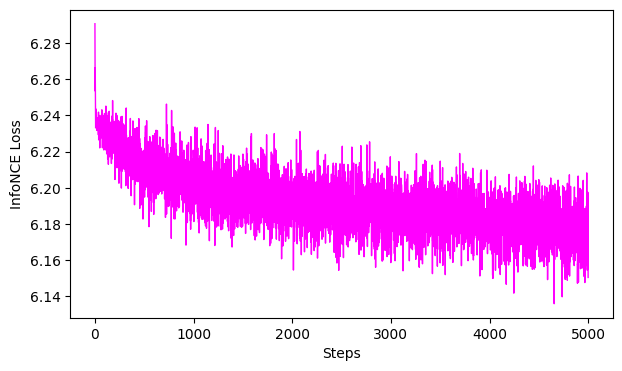

In [25]:
#fit, transform
cebra_shuffled_model.fit(shuffled_neural, hippocampus_pos.continuous_index.numpy())
cebra_neural_shuffled = cebra_shuffled_model.transform(shuffled_neural)
# GoF
gof_full = cebra.sklearn.metrics.goodness_of_fit_score(cebra_shuffled_model, shuffled_neural,hippocampus_pos.continuous_index.numpy())
print(" GoF in bits - full:", gof_full)
# plot embedding
fig = cebra.integrations.plotly.plot_embedding_interactive(cebra_neural_shuffled, embedding_labels=hippocampus_pos.continuous_index[:,0], title = "CEBRA-Behavior (neural shuffled)", markersize=3, cmap = "rainbow")
fig.show()
# plot the loss curve
ax = cebra.plot_loss(cebra_shuffled_model)

## Where do you land? 🚨

The shuffles with the same parameters should not show any structure, the GoF close to 0, and the loss curve should not drop late in training (which would be overfitting).

If this is the case, then you have good parameters to go forth with! 🦓🍾

### What's next?

We recommend using these embeddings for model comparisons, decoding, explainable AI (xCEBRA), and/or representation analysis!